# GONZAG / NEMO South-East New Caledonia at 60<sup>th</sup> of a degree: tide vs no tide

This notebook demonstrates how Gonzag can be used to:
- perform a space-time interpolation of SSH on a gridded OGCM domain onto a satellite track (provided in 2 NetCDF input files)
- select and retain N valid SSH along track segments (both for input satellite SSH and interpolated model SSH)
- preprocess these N SSH segments prior to applying a Fast Fourrier Transform (FFT)
- apply the FFT
- plot the the mean spectrum (of the N spectra)

## Loading & initializations

In [1]:
import sys
from os import getenv
import warnings
warnings.filterwarnings("ignore")

GONZAG_DIR   = getenv('HOME')+'/DEV/GONZAG/gonzag'
sys.path.append(GONZAG_DIR)

import gonzag as gzg
from gonzag.config import ldebug

GONZAG_DATA_DIR = '/MEDIA/data/GONZAG/gonzag_input'

# Satellite input data:
name_sat = 'Sentinel3A'
file_sat = GONZAG_DATA_DIR+'/SARAL_20170101-20170331.nc'
name_ssh_sat = 'sla_unfiltered'

# Model input data:
name_mod = 'CaledoSE'
file_mod = GONZAG_DATA_DIR+'/zos_'+name_mod+'_2017_JFM_hourly.nc'
name_ssh_mod = 'zos'
file_lsm_mod = file_mod; name_lsm_mod = '_FillValue' ; # we use _FillValue attribute of "nams_ssh_mod" in "file_mod"
l_griddist = False ; # grid is not strongly distorded
# No-tide version:
name_mod_nt = 'CaledoSE_NoTide'
file_mod_nt = GONZAG_DATA_DIR+'/zos_'+name_mod_nt+'_2017_JFM_hourly.nc'
file_lsm_mod_nt = file_mod_nt




### Time overlap between model and satellite data ?

In [2]:
    (it1,it2), (Nts,Ntm) = gzg.GetEpochTimeOverlap( file_sat , file_mod )
    print(' *** Time overlap between model and satellite in UNIX epoch time: it1, it2', it1,'--',it2)
    print('   => UTC: "'+gzg.EpochT2Str(it1)+'" to "'+gzg.EpochT2Str(it2)+'"\n')


 *** Time overlap between model and satellite in UNIX epoch time: it1, it2 1483230600.0 -- 1491003000.0
   => UTC: "Sun Jan  1 00:30:00 2017" to "Fri Mar 31 23:30:00 2017"



## Create object `ModelGrid` containing all the model (aka _source_) 2D+T domain grid info

In [3]:
    clsm = name_lsm_mod
    if name_lsm_mod=='_FillValue': clsm = name_lsm_mod+'@'+name_ssh_mod
    
    ModelGrid    = gzg.ModGrid( file_mod, it1, it2, file_lsm_mod, clsm, distorded_grid=l_griddist )
    ModelGrid_nt = gzg.ModGrid( file_mod_nt, it1, it2, file_lsm_mod_nt, clsm, distorded_grid=l_griddist )



 *** what we use to define model land-sea mask:
    => "_FillValue@zos" in "/MEDIA/data/GONZAG/gonzag_input/zos_CaledoSE_2017_JFM_hourly.nc"

 *** Skipping computation of angle distortion of the model grid! ("-D" option not invoked)...

 *** About model gridded (source) domain:
     * shape =  (301, 291)
     * horizontal resolution:  0.016666649127828663  degrees or  1.8518313845930428  km
     * Is this a global domain w.r.t longitude:  False
       ==> this is a regional domain
       ==> working in the [0:360] frame...
     * lon_min, lon_max =  165.23 170.07
     * lat_min, lat_max =  -25.84 -21.26
     * should we pay attention to possible STRONG local distorsion in the grid:  False
     * number of time records of interest for the interpolation to come:  2160
       ==> time record indices: 0 to 2159, included


 *** what we use to define model land-sea mask:
    => "_FillValue@zos" in "/MEDIA/data/GONZAG/gonzag_input/zos_CaledoSE_NoTide_2017_JFM_hourly.nc"

 *** Skipping compu

## Create object `SatelliteTrack` containing all the satellite track (aka _target_) info

In [4]:
SatelliteTrack = gzg.SatTrack( file_sat, it1, it2, Np=Nts, \
                              domain_bounds=ModelGrid.domain_bounds, l_0_360=ModelGrid.l360 )

 *** [SatTrack()] Analyzing the time vector in /MEDIA/data/GONZAG/gonzag_input/SARAL_20170101-20170331.nc ...

 *** About satellite track (target) domain:
     * number of time records of interest for the interpolation to come:  2390
       ==> time record indices: 1550 to 4127111, included



## Build the bilinear mapping & Perform the space-time interpolation

In [5]:
Solution_Tide = gzg.Model2SatTrack( ModelGrid, name_ssh_mod, SatelliteTrack, name_ssh_sat )

 *** "found" distance criterion when searching for nearest point on model grid is  1.3888735384447821  km

 *** Will use zoom boxes of width of 271 points for 1st attempts of nearest-point location...


 *** Finding nearest points on source (model) grid... (rd_found_km, np_box_r = 1.3888735384447821 135 )
      +++ Treated point: 239/2390 
          ==> Sat. coordinates:     -24.194 166.4
          ==> Model nearest point:  -24.197 166.4  ( 109 70 )
      +++ Treated point: 478/2390 
          ==> Sat. coordinates:     -23.415 169.526
          ==> Model nearest point:  -23.419 169.533  ( 160 258 )
      +++ Treated point: 717/2390 
          ==> Sat. coordinates:     -24.991 168.687
          ==> Model nearest point:  -24.985 168.683  ( 57 207 )
      +++ Treated point: 956/2390 
          ==> Sat. coordinates:     -22.815 167.706
          ==> Model nearest point:  -22.821 167.7  ( 199 148 )
      +++ Treated point: 1195/2390 
          ==> Sat. coordinates:     -21.774 167.557
     

In [6]:
Solution_NoTide = gzg.Model2SatTrack( ModelGrid_nt, name_ssh_mod, SatelliteTrack, name_ssh_sat )

 *** "found" distance criterion when searching for nearest point on model grid is  1.3888735384447821  km

 *** Will use zoom boxes of width of 271 points for 1st attempts of nearest-point location...


 *** Finding nearest points on source (model) grid... (rd_found_km, np_box_r = 1.3888735384447821 135 )
      +++ Treated point: 239/2390 
          ==> Sat. coordinates:     -24.194 166.4
          ==> Model nearest point:  -24.197 166.4  ( 109 70 )
      +++ Treated point: 478/2390 
          ==> Sat. coordinates:     -23.415 169.526
          ==> Model nearest point:  -23.419 169.533  ( 160 258 )
      +++ Treated point: 717/2390 
          ==> Sat. coordinates:     -24.991 168.687
          ==> Model nearest point:  -24.985 168.683  ( 57 207 )
      +++ Treated point: 956/2390 
          ==> Sat. coordinates:     -22.815 167.706
          ==> Model nearest point:  -22.821 167.7  ( 199 148 )
      +++ Treated point: 1195/2390 
          ==> Sat. coordinates:     -21.774 167.557
     


## Objects `Solution_Tide` and  `Solution_NoTide` contain everything you need to start the plots and the science... 

### 1] Plot the nearest points on the model domain

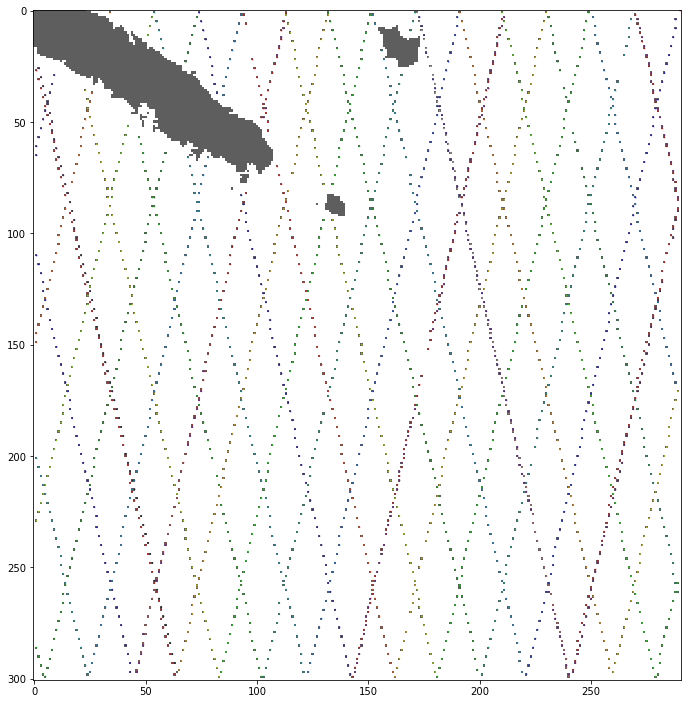

In [7]:
import numpy as nmp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

XFLD = nmp.flipud(Solution_Tide.XNPtrack)
(idy,idx) = nmp.where( XFLD > 0 ) ; # that's track points...

XMSK = 1 - nmp.ma.getmask(XFLD).astype(nmp.int8)
pmsk = nmp.ma.masked_where(XMSK<0.1, XMSK*0.7)
del XMSK

(Nj,Ni) = XFLD.shape

fig = plt.figure(num = 1, figsize=(9,9*Nj/Ni), facecolor='w', edgecolor='k')
ax  = plt.axes([0., 0., 1., 1.],     facecolor = 'w')
norm_fld = colors.Normalize(vmin =nmp.amin(XFLD[(idy,idx)]), vmax=nmp.amax(XFLD[(idy,idx)]), clip = False)
cf = ax.scatter(idx, idy, c=XFLD[(idy,idx)], cmap = 'nipy_spectral', norm = norm_fld, alpha=0.5, marker='.', s=3 )
#
norm_lsm = colors.Normalize(vmin = 0., vmax = 1., clip = False)
cm = ax.imshow(pmsk, cmap='Greys', norm=norm_lsm, interpolation='none')


### 2] Plot time series of _interpolated model_ SLA and satellite SLA

Even if probably ugly it gives the pictures of what we are dealing with...

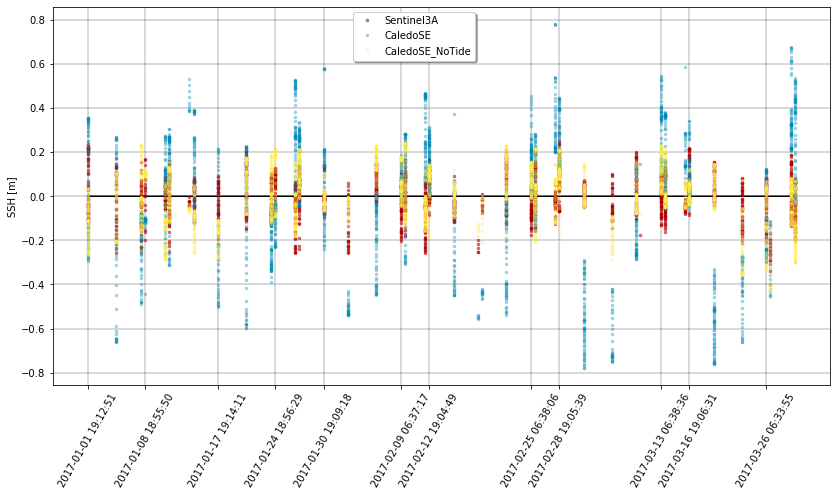

In [18]:
import matplotlib.dates as mdates
                                                                                                        
clr_sat = '#AD0000'
clr_mod_tide = '#008ab8'
clr_mod_notide = '#FFED47'

VT = mdates.epoch2num(Solution_NoTide.time) ; # time from UNIX Epoch to Matlplotlib friendly...

fig = plt.figure(num = 1, figsize=(12,7), facecolor='w', edgecolor='k')
ax = plt.axes([0.07, 0.24, 0.9, 0.75])
ax.set_xticks(VT[::200])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation='60')
plt.plot(VT, VT*0.0          , '-', color='k',                   label=None,  zorder=5)
plt.plot(VT, Solution_NoTide.ssh_sat-nmp.mean(Solution_NoTide.ssh_sat), '.', color=clr_sat, markersize=5, alpha=0.5, label=name_sat, zorder=10)
plt.plot(VT, Solution_Tide.ssh_mod-nmp.mean(Solution_Tide.ssh_mod), '.', color=clr_mod_tide, markersize=5, alpha=0.3, label=name_mod, zorder=15)
plt.plot(VT, Solution_NoTide.ssh_mod-nmp.mean(Solution_NoTide.ssh_mod), '.', color=clr_mod_notide, markersize=5, alpha=0.3, label=name_mod_nt, zorder=15)

#ax.set_ylim(-r_max_amp_ssh,r_max_amp_ssh) ;
#ax.set_ylim(-20,20)
#ax.set_xlim(VT[0],VT[-1])
plt.ylabel('SSH [m]')
ax.grid(color='k', linestyle='-', linewidth=0.3)
lgnd = plt.legend(bbox_to_anchor=(0.55, 1.), ncol=1, shadow=True, fancybox=True)


## Processing solution for spectral analysis
### 1] Select continuous segments, prepare them for FFT, and apply FFT on each of them

In [36]:
# Extract the Ns continuous data segments:                                                                                                              
ISeg_beg, ISeg_end = gzg.FindUnbrokenSegments( Solution_Tide.time, Solution_Tide.distance, Solution_Tide.ssh_mod, \
                                             rcut_time=1.2, rcut_dist=7.8 )
# => any Δt > 1.2 s between 2 consecutive points is considered as a gap and hence a cut!
# => any Δd > 7.8 km    "               "             "                 "

# Select and retain only the "NbSeg" proper segments:                                                                                                               
NbSeg, Nsl, IDEDSeg = gzg.SegmentSelection(ISeg_beg, ISeg_end, np_valid_seg=50)
# Debug validity check:                                                                                                                                       
#for js in range(NbSeg):                                                                                                                                
#    print(' * Seg # ',js+1,' => it1, it2 =', IDEDSeg[js,:], ' ==> len = ', IDEDSeg[js,1]-IDEDSeg[js,0]+1)                                              
#print(' Nsl = ',Nsl)

# Process data on segment so ready for FFT:                                                                                                 
XPs, XPm, rdist_sample = gzg.Process4FFT( IDEDSeg, Solution_Tide.distance, Solution_Tide.ssh_mod, Solution_Tide.ssh_sat )

# Apply FFT !                                                                                                                               
Kwn, PwSpc_s, PwSpc_tide_m = gzg.ApplyFFT( IDEDSeg, XPs, XPm, rdist_sample )


 *** [SegmentSelection()]: Will use 10 segments with a fixed length of 60 points!
     ==> 10 selected segments out of the 92 available (requested minimum length is 50 points)

 *** [Process4FFT()]: applying linear detrending...
 *** [Process4FFT()]: centering about 0...
 *** [Process4FFT()]: applying "Tukey" tappering...

 *** [ApplyFFT()]: Applying FFT with a dx_sample of  7.024  km



In [37]:
# Same for non-tidal experiment:
del ISeg_beg, ISeg_end, NbSeg, Nsl, XPs, XPm, rdist_sample

ISeg_beg, ISeg_end = gzg.FindUnbrokenSegments( Solution_NoTide.time, Solution_NoTide.distance, Solution_NoTide.ssh_mod, \
                                             rcut_time=1.2, rcut_dist=7.8 )
                                                                                                               
NbSeg, Nsl, IDEDSeg = gzg.SegmentSelection(ISeg_beg, ISeg_end, np_valid_seg=50)
                                                                                              
XPs, XPm, rdist_sample = gzg.Process4FFT( IDEDSeg, Solution_NoTide.distance, Solution_NoTide.ssh_mod, Solution_NoTide.ssh_sat )
                                                                                                                             
Kwn_notide, PwSpc_notide_s, PwSpc_notide_m = gzg.ApplyFFT( IDEDSeg, XPs, XPm, rdist_sample )

 *** [SegmentSelection()]: Will use 10 segments with a fixed length of 60 points!
     ==> 10 selected segments out of the 92 available (requested minimum length is 50 points)

 *** [Process4FFT()]: applying linear detrending...
 *** [Process4FFT()]: centering about 0...
 *** [Process4FFT()]: applying "Tukey" tappering...

 *** [ApplyFFT()]: Applying FFT with a dx_sample of  7.024  km



### 2] Plotting the mean spectrum

In [40]:
CLIMPORN_DIR = getenv('HOME')+'/DEV/climporn/python' ; # get it there: https://github.com/brodeau/climporn
sys.path.append(CLIMPORN_DIR)
import climporn as cp


# Building our spectrum as the mean of the NbSeg spectra:
vps_mod_tide   = nmp.mean(PwSpc_tide_m[:,:],axis=0)
vps_mod_notide = nmp.mean(PwSpc_notide_m[:,:],axis=0)
vps_sat = nmp.mean(PwSpc_s[:,:],axis=0)




# Blabla for the plot:
cinfrm = str(NbSeg)+' segments\n'+str(Nsl)+' points/segment\n'+r'$\Delta$d sat.: '+str(round(rdist_sample,1))+' km'

ii = cp.plot("pow_spectrum_ssh")(Kwn, vps_sat, clab1=name_sat, clr1=clr_sat, lw1=5, \
                                 cinfo=cinfrm, logo_on=False, \
                                 L_min=13., L_max=500., P_min_y=-6, P_max_y=1, \
                                 l_show_k4=False, l_show_k5=True, l_show_k11o3=False, l_show_k2=True, \
                                 vk2=Kwn, vps2=vps_mod_tide,   clab2=name_mod,    clr2=clr_mod_tide,   lw2=4, \
                                 vk3=Kwn, vps3=vps_mod_notide, clab3=name_mod_nt, clr3=clr_mod_notide, lw3=8)


0.00036625547294268605 0.00036625547294268605
0.0002831099695086211 0.0002831099695086211
0.0010653353837473825 0.0010653353837473825
0.0023103498413261747 0.0023103498413261747
0.005264701589695707 0.005264701589695707
0.0032806975728158637 0.0032806975728158637
0.00430174265985214 0.00430174265985214
0.0020550496670946345 0.0020550496670946345
0.0024367261565610954 0.0024367261565610954
0.000944488019419253 0.000944488019419253
0.001104923549414788 0.001104923549414788
0.00031180863925137715 0.00031180863925137715
0.0009237398850062826 0.0009237398850062826
0.010634706192374844 0.010634706192374844
0.0037240941280752837 0.0037240941280752837
0.00023713592773799764 0.00023713592773799764
0.006387710286642704 0.006387710286642704
7.384556594460292e-05 7.384556594460292e-05
0.006443905992669139 0.006443905992669139
0.007068159753100321 0.007068159753100321
0.011331639010560795 0.011331639010560795
0.000372676459566242 0.000372676459566242
0.007771517578848623 0.007771517578848623
0.0188

IndexError: index 60 is out of bounds for axis 1 with size 60